In [1]:
from language import Language
from train import train, init_model
from transformers import GPT2Config, GPT2LMHeadModel
import torch

from sklearn.decomposition import PCA
import pandas as pd
import plotnine as p9

device = "cpu"

/Users/aryamanarora/Documents/Code/tinylang/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
language = Language(num_verbs=20, num_nouns=20)

In [3]:
model_dict = {}
loss_dict = {}
for layers in range(4):
    n_embd = 16
    config = GPT2Config(
        vocab_size=language.vocab_size,
        n_positions=5,
        n_embd=n_embd,
        n_layer=layers,
        n_head=2,
        n_inner=4 * n_embd,
        activation_function="gelu_new",
        resid_pdrop=0.0,
        embd_pdrop=0.0,
        attn_pdrop=0.0,
        layer_norm_epsilon=1e-5,
        initializer_range=0.02,
        summary_type="cls_index",
    )
    model = GPT2LMHeadModel(config).to(device)
    losses = train(model, language, num_steps=5000)
    loss_dict[layers] = losses
    model.eval()
    model_dict[layers] = model


Parameters: 0.000784M


Training: 100%|██████████| 5000/5000 [00:25<00:00, 195.70it/s, loss=2.12]


Parameters: 0.004064M


Training: 100%|██████████| 5000/5000 [00:41<00:00, 120.28it/s, loss=1.93]


Parameters: 0.007344M


Training: 100%|██████████| 5000/5000 [00:54<00:00, 90.98it/s, loss=1.97] 


Parameters: 0.010624M


Training: 100%|██████████| 5000/5000 [01:04<00:00, 77.90it/s, loss=1.94]


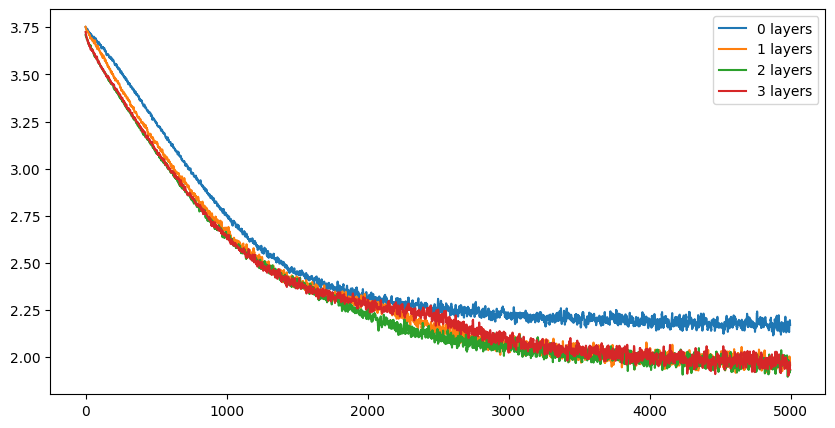

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# plot smoothed losses for each number of layers
plt.figure(figsize=(10, 5))
for layers, losses in loss_dict.items():
    losses_smoothed = np.convolve(losses, np.ones(5) / 5, mode='valid')
    plt.plot(losses_smoothed, label=f'{layers} layers')
plt.legend()
plt.show()


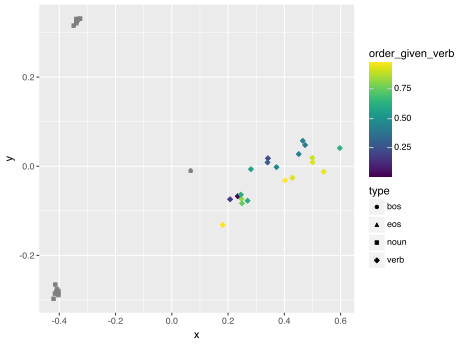

In [7]:
# use svg in jupyter
%config InlineBackend.figure_format = 'svg'

for layers in range(2, 3):
    model = model_dict[layers]
    embeddings = model.transformer.wte.weight.data
    embeddings[language.EOS] = embeddings[language.BOS]
    pca = PCA(n_components=3)
    embeddings_pca = pca.fit_transform(embeddings)

    # make data frame
    def color_by_verb_noun(i):
        if i == language.BOS:
            return "bos"
        elif i == language.EOS:
            return "eos"
        elif i < language.VERB_START:
            return "other"
        elif i < language.NOUN_START:
            return "verb"
        else:
            return "noun"
    df = pd.DataFrame(embeddings_pca[:, :2], columns=['x', 'y'])
    df['type'] = df.index.map(color_by_verb_noun)
    df['order_given_verb'] = df.index.map(lambda i: language.p_order_given_verb[i - language.VERB_START, 0].item() if i >= language.VERB_START and i < language.NOUN_START else None)

    plot = (p9.ggplot(df, p9.aes(x='x', y='y', color='order_given_verb', shape='type')) + p9.geom_point())
    plot.show()


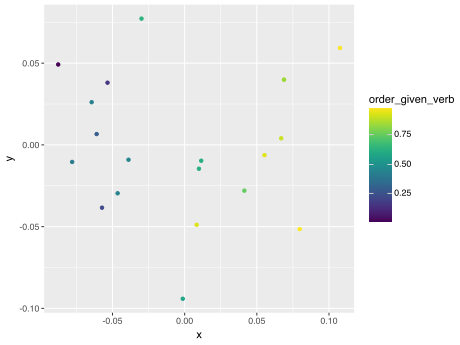

In [13]:
# use svg in jupyter
%config InlineBackend.figure_format = 'svg'

for layers in range(2, 3):
    model = model_dict[layers]
    embeddings = model.transformer.wte.weight.data[language.VERB_START:language.NOUN_START, :]
    embeddings[language.EOS] = embeddings[language.BOS]
    pca = PCA(n_components=3)
    embeddings_pca = pca.fit_transform(embeddings)

    # make data frame
    df = pd.DataFrame(embeddings_pca[:, 1:3], columns=['x', 'y'])
    df['order_given_verb'] = df.index.map(lambda i: language.p_order_given_verb[i, 0].item())

    plot = (p9.ggplot(df, p9.aes(x='x', y='y', color='order_given_verb')) + p9.geom_point())
    plot.show()
